[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# One Dimensional Kalman Filters

In [1]:
#format the book
%matplotlib inline
import book_format
from book_format import *
book_format.load_style()

## One Dimensional Kalman Filters

Now that we understand the histogram filter and Gaussians we are prepared to implement a 1D Kalman filter. We will do this exactly as we did the histogram filter - rather than going into the theory we will just develop the code step by step.

## Tracking A Dog

As in the histogram chapter we will be tracking a dog in a long hallway at work. However, in our latest hackathon someone created an RFID tracker that provides a reasonable accurate position for our dog. Suppose the hallway is 100m long. The sensor returns the distance of the dog from the left end of the hallway. So, 23.4 would mean the dog is 23.4 meters from the left end of the hallway.

Naturally, the sensor is not perfect. A reading of 23.4 could correspond to a real position of 23.7, or 23.0. However, it is very unlikely to correspond to a real position of say 47.6. Testing during the hackathon confirmed this result - the sensor is reasonably accurate, and while it had errors, the errors are small. Furthermore, the errors seemed to be evenly distributed on both sides of the measurement; a true position of 23m would be equally likely to be measured as 22.9 as 23.1.

Implementing and/or robustly modeling an RFID system is beyond the scope of this book, so we will write a very simple model. We will start with a simulation of the dog moving from left to right at a constant speed with some random noise added. We will talk about this in great detail later, but we need to model two kinds of noise. The *process noise* is the noise in the physical process. Something moving at a notionally 'constant' velocity will never maintain a perfectly constant velocity. Undulations on the ground, wind, and a host of other factors mean that there will always be slight variations in the velocity. The second noise we want to model is the noise in the measurement as no measurement is perfect.

In [2]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy.random as random
import math

class DogSensor(object):
    
    def __init__(self, x0=0, velocity=1, 
                 measurement_variance=0.0, process_variance=0.0):
        """ x0 - initial position
            velocity - (+=right, -=left)
            measurement_variance - variance in measurement
            process_variance - variance in process (m/s)^2
        """
        self.x = x0
        self.velocity = velocity
        self.noise = math.sqrt(measurement_variance)
        self.pnoise = math.sqrt(process_variance)
        self.constant_vel = velocity

    def sense_position(self):
        pnoise = abs(random.rand() * self.pnoise)
        if self.velocity > self.constant_vel:
            pnoise = -pnoise
        self.velocity += pnoise
        self.x = self.x + self.velocity
        return self.x + random.randn() * self.noise

The constructor `_init()__` initializes the DogSensor class with an initial position `x0`, velocity `vel`, and the variance in the measurement and noise. The `sense_position()` function has the dog move by the set velocity and returns its new position, with noise added. If you look at the code for `sense_position()` you will see a call to `numpy.random.randn()`. This returns a number sampled from a normal distribution with a mean of 0.0. and a standard deviation of 1.0. *Variance* is defined as the standard deviation squared, so in `__init()__` we take the square root of the variances to get the standard deviation. Therefore the expression `self.x + random.randn() * self.noise` computes a simulated measurement with the variance that we desire. 

Let's look at some example output for that.

In [3]:
for i in range(20):
    print('{: 5.4f}'.format(random.randn()), end='\t')
    if (i+1) % 5 == 0:
        print ('')

 0.4293	-2.4606	 0.5406	-1.0854	 0.8824	
 0.0225	-1.0454	 0.7260	-0.2236	-0.4063	
 0.1890	 1.3218	-0.2226	 1.7665	-1.4184	
-0.5187	 0.1318	-0.9789	 0.0092	 0.0671	


You should see a sequence of numbers near 0, some negative and some positive. Most are probably between -1 and 1, but a few might lie somewhat outside that range. This is what we expect from a normal distribution - values are clustered around the mean, and there are fewer values the further you get from the mean.

Okay, so lets look at the output of the `DogSensor` class. We will start by setting the variance to 0 to check that the class does what we think it does. Zero variance means there is no noise in the signal, so the results should be a straight line.

1.0000 2.0000 3.0000 4.0000 5.0000 6.0000 7.0000 8.0000 9.0000 10.0000 

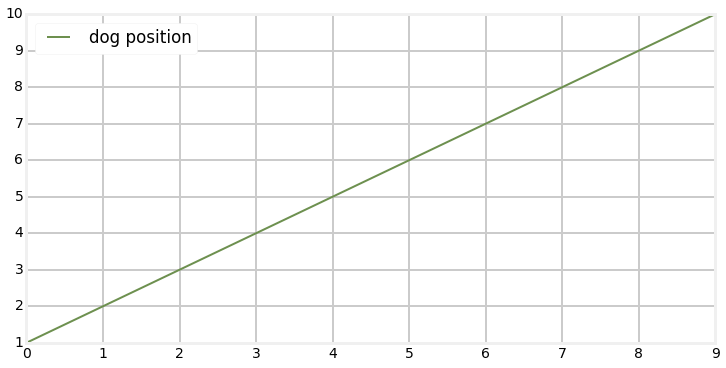

In [4]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import book_plots as bp

dog = DogSensor(measurement_variance=0.0)
xs = []
for i in range(10):
    x = dog.sense_position()
    xs.append(x)
    print("%.4f" % x, end=' '),
bp.plot_track(xs, label='dog position')
plt.legend(loc='best')
plt.show()

The constructor initialized the dog at position 0 with a velocity of 1 (move 1.0 to the right). So we would expect to see an output of 1..10, and indeed that is what we see. If you thought the correct answer should have been 0..9 recall that `sense()` returns the dog's position *after* updating his position, so the first position is 0.0 + 1, or 1.0.

Now let's inject some noise in the signal.

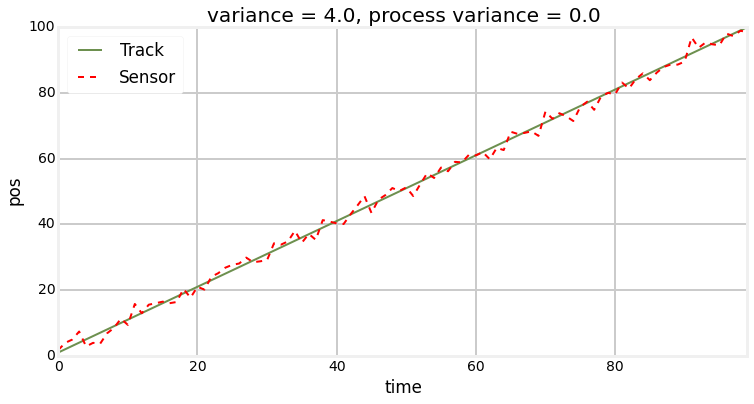

In [5]:
def test_sensor(measurement_var, process_var=0.0):
    dog = DogSensor(measurement_variance=measurement_var, 
                    process_variance=process_var)

    xs = []
    for i in range(100):
        x = dog.sense_position()
        xs.append(x)

    bp.plot_track([0, 99], [1, 100])
    bp.plot_measurements(xs, label='Sensor')
    plt.xlabel('time')
    plt.ylabel('pos')
    plt.ylim([0,100])
    plt.title('variance = {}, process variance = {}'.format(
               measurement_var, process_var))
    plt.legend(loc='best')
    plt.show()

test_sensor(measurement_var=4.0)


> **Note**: numpy uses a random number generator to generate the normal distribution samples. The numbers I see as I write this are unlikely to be the ones that you see. If you run the cell above multiple times, you should get a slightly different result each time. I could use `numpy.random.seed(some_value)` to force the results to be the same each time. This would simplify my explanations in some cases, but would ruin the interactive nature of this chapter. To get a real feel for how normal distributions and Kalman filters work you will probably want to run cells several times, observing what changes, and what stays roughly the same.

So the output of the sensor should be a wavering blue line drawn over a dotted red line. The dotted red line shows the actual position of the dog, and the blue line is the noise signal produced by the simulated RFID sensor. Please note that the red dotted line was manually plotted - we do not yet have a filter that recovers that information! 

If you are running this in an interactive IPython Notebook, I strongly urge you to run the script several times in a row. You can do this by putting the cursor in the cell containing the Python code and pressing CTRL+Enter. Each time it runs you should see a different jagged blue line wavering over the top of the dotted red line.

I also urge you to adjust the noise setting to see the result of various values. However, since you may be reading this in a read only notebook, I will show several examples. The first plot shows the noise set to 100.0, and the second shows noise set to 0.5.

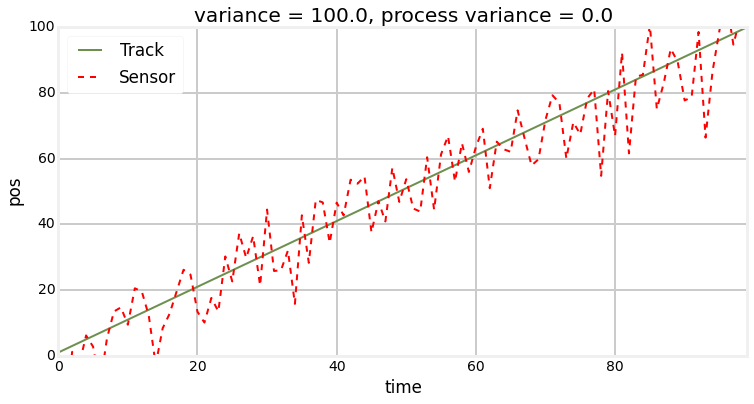

In [6]:
test_sensor(measurement_var=100.0)

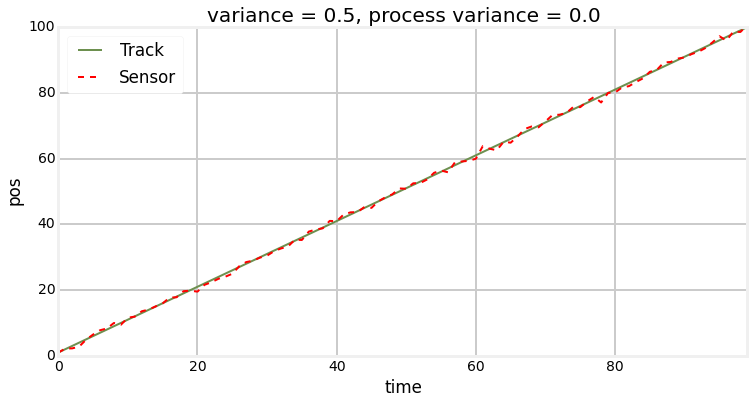

In [7]:
test_sensor(measurement_var=0.5)

Now lets see the effect of the process noise. My simulation is not meant to exactly model any given physical process. On each call to `sense_position()` I modify the current velocity by randomly generated process noise. However, I strive to keep the velocity close to the initial value, as I am assuming that there is a control mechanism in place trying to maintain the same speed. In this case, the control mechanism would be the dog's brain! For an automobile it could be a cruise control or the human driver.

So let's first look at the plot with some process noise but no measurement noise to obscure the results.

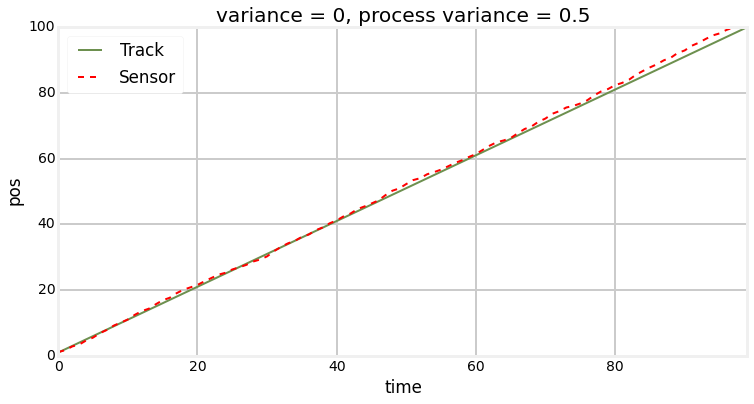

In [8]:
import numpy as np
np.random.seed(1234)
test_sensor(measurement_var=0, process_var=0.5)

We can see that the position wanders slightly from the ideal track. You may have thought that the track would have wandered back and forth the ideal path like the measurement noise did, but recall that we are modifying velocity on each, not the position. So once the track has deviated, it will stay there until the random changes in velocity happen to result in the track going back to the original track. 

Finally, let's look at the combination of measurement noise and process noise.

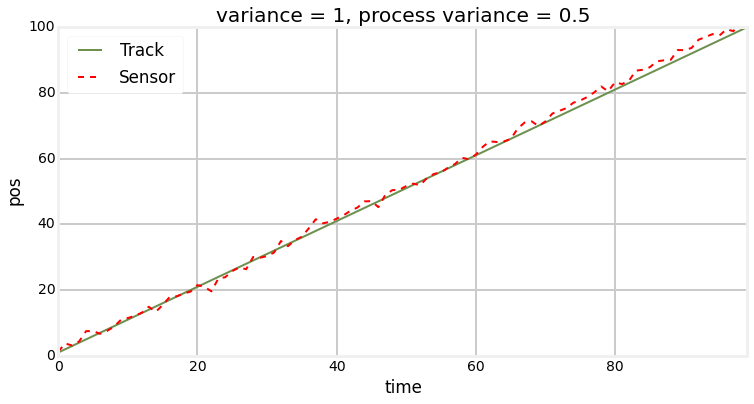

In [9]:
test_sensor(measurement_var=1, process_var=0.5)

## Math with Gaussians

Let's say we believe that our dog is at 23m, and the variance is 5, or $pos_{dog}=\mathcal{N}(23,5)$). We can represent that in a plot:

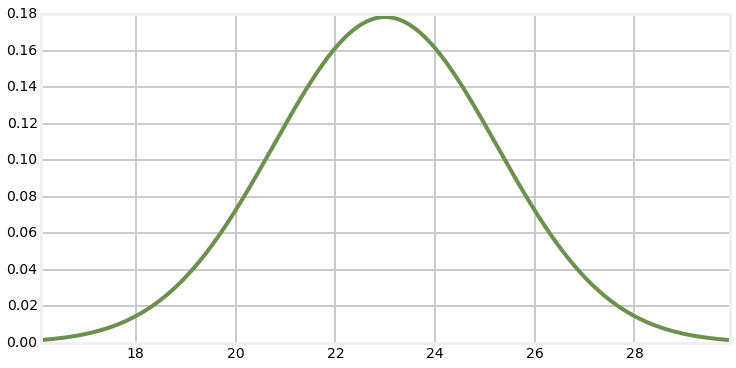

In [10]:
import stats
stats.plot_gaussian(mean=23, variance=5)

This corresponds to a fairly inexact belief. While we believe that the dog is at 23, note that roughly 21 to 25 are quite likely as well. Let's assume for the moment our dog is standing still, and we query the sensor again. This time it returns 23.2 as the position. Can we use this additional information to improve our estimate of the dog's position?

Intuition suggests 'yes'. Consider: if we read the sensor 100 times and each time it returned a value between 21 and 25, all centered around 23, we should be very confident that the dog is somewhere very near 23. Of course, a different physical interpretation is possible. Perhaps our dog was randomly wandering back and forth in a way that exactly emulated a normal distribution. But that seems extremely unlikely - I certainly have never seen a dog do that. So the only reasonable assumption is that the dog was mostly standing still at 23.0.

Let's look at 100 sensor readings in a plot:

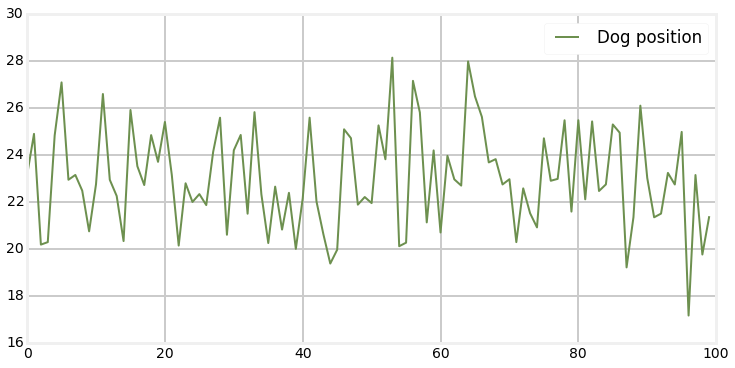

In [11]:
dog = DogSensor(x0=23, velocity=0, 
                measurement_variance=5, process_variance=0.0)
xs = range(100)
ys = []
for i in xs:
    ys.append(dog.sense_position())
               
bp.plot_track(xs,ys, label='Dog position')
plt.legend(loc='best')
plt.show()

Eyeballing this confirms our intuition - no dog moves like this. However, noisy sensor data certainly looks like this. So let's proceed and try to solve this mathematically. But how?


Recall the histogram code for adding a measurement to a preexisting belief:

    def update(pos, measure, p_hit, p_miss):
        q = array(pos, dtype=float)
        for i in range(len(hallway)):
            if hallway[i] == measure:
                q[i] = pos[i] * p_hit
            else:
                q[i] = pos[i] * p_miss
         normalize(q)
         return q
         
Note that the algorithm is essentially computing:

    new_belief = old_belief * measurement * sensor_error
    
The measurement term might not be obvious, but recall that measurement in this case was always 1 or 0, and so it was left out for convenience. 
    
If we are implementing this with Gaussians, we might expect it to be implemented as:

    new_gaussian = measurement * old_gaussian
    
where measurement is a Gaussian returned from the sensor. But does that make sense? Can we multiply gaussians? If we multiply a Gaussian with a Gaussian is the result another Gaussian, or something else?

It is not particularly difficult to perform the algebra to derive the equation for multiplying two Gaussians, but I will just present the result:
$$
N(\mu_1, \sigma_1^2)*N(\mu_2, \sigma_2^2) = N(\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1}{\sigma_1^2 + \sigma_2^2},\frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}}) $$ 

In other words the result is a Gaussian with 

$$\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}}
\end{aligned}$$

Without doing a deep analysis we can immediately infer some things. First and most importantly the result of multiplying two Gaussians is another Gaussian. The expression for the mean is not particularly illuminating, except that it is a combination of the means and variances of the input. But the variance of the result is merely some combination of the variances of the variances of the input. We conclude from this that the variances are completely unaffected by the values of the mean!

Let's immediately look at some plots of this. First, let's look at the result of multiplying $N(23,5)$ to itself. This corresponds to getting 23.0 as the sensor value twice in a row. But before you look at the result, what do you think the result will look like? What should the new mean be? Will the variance by wider, narrower, or the same?

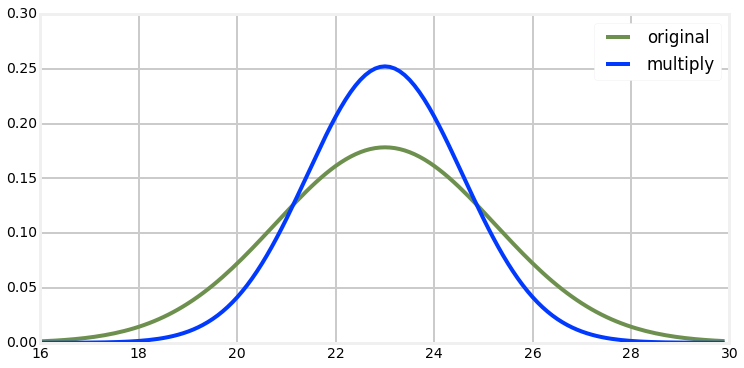

In [12]:
from __future__ import division
import numpy as np

def multiply(mu1, var1, mu2, var2):
    if var1 == 0.0:
        var1=1.e-80
        
    if var2 == 0:
        var2 = 1e-80
        
    mean = (var1*mu2 + var2*mu1) / (var1+var2)
    variance = 1 / (1/var1 + 1/var2)
    return (mean, variance)

xs = np.arange(16, 30, 0.1)

mean1, var1 = 23, 5
mean, var = multiply(mean1, var1, mean1, var1)

ys = [stats.gaussian(x, mean1, var1) for x in xs]
plt.plot (xs, ys, label='original')

ys = [stats.gaussian(x, mean, var) for x in xs]
plt.plot (xs, ys, label='multiply')

plt.legend(loc='best')
plt.show()

The result is either amazing or what you would expect, depending on your state of mind. I must admit I vacillate freely between the two! Note that the result of the multiplication is taller and narrow than the original Gaussian but the mean is the same. Does this match your intuition of what the result should have been?

If we think of the Gaussians as two measurements, this makes sense. If I measure twice and get the same value, I should be more confident in my answer than if I just measured once. If I measure twice and get 23 meters each time, I should conclude that the length is close to 23 meters. So the mean should be 23. I am more confident with two measurements than with one, so the variance of the result should be smaller. 

"Measure twice, cut once" is a useful saying and practice due to this fact!  The Gaussian is just a mathematical model of this physical fact, so we should expect the math to follow our physical process. 

Now let's multiply two Gaussians (or equivalently, two measurements) that are partially separated. In other words, their means will be different, but their variances will be the same. What do you think the result will be? Think about it, and then look at the graph.

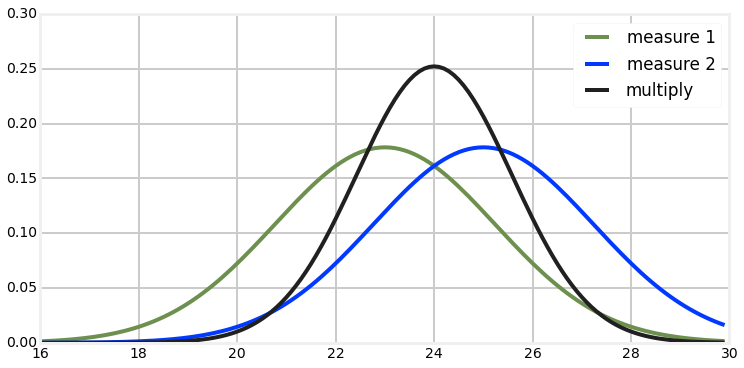

In [13]:
xs = np.arange(16, 30, 0.1)

mean1, var1 = 23, 5
mean2, var2 = 25, 5
mean, var = multiply(mean1, var1, mean2, var2)

ys = [stats.gaussian(x, mean1, var1) for x in xs]
plt.plot(xs, ys, label='measure 1')

ys = [stats.gaussian(x, mean2, var2) for x in xs]
plt.plot(xs, ys, label='measure 2')

ys = [stats.gaussian(x, mean, var) for x in xs]
plt.plot(xs, ys, label='multiply')
plt.legend()
plt.show()

Another beautiful result! If I handed you a measuring tape and asked you to measure the distance from table to a wall, and you got 23m, and then a friend make the same measurement and got 25m, your best guess must be 24m. 

That is fairly counter-intuitive, so let's consider it further. Perhaps a more reasonable assumption would be that either you or your coworker just made a mistake, and the true distance is either 23 or 25, but certainly not 24. Surely that is possible. However, suppose the two measurements you reported as 24.01 and 23.99. In that case you would agree that in this case the best guess for the correct value is 24?  Which interpretation we choose depends on the properties of the sensors we are using. Humans make galling mistakes, physical sensors do not. 

This topic is fairly deep, and I will explore it once we have completed our Kalman filter. For now I will merely say that the Kalman filter requires the interpretation that measurements are accurate, with Gaussian noise, and that a large error caused by misreading a measuring tape is not Gaussian noise.

For now I ask that you trust me. The math is correct, so we have no choice but to accept it and use it. We will see how the Kalman filter deals with movements vs error very soon. In the meantime, accept that 24 is the correct answer to this problem.

One final test of your intuition. What if the two measurements are widely separated? 

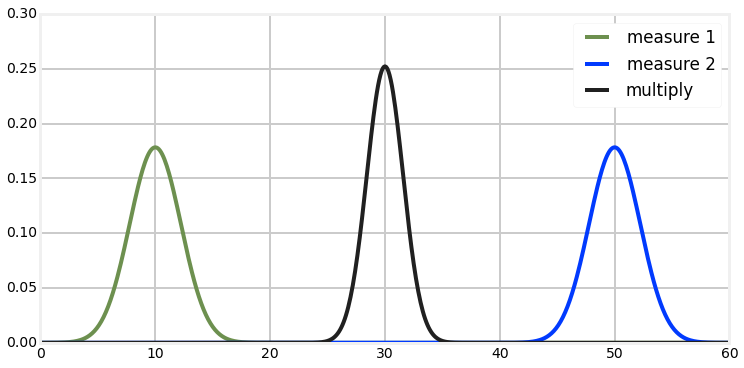

In [14]:
xs = np.arange(0, 60, 0.1)

mean1, var1 = 10, 5
mean2, var2 = 50, 5
mean, var = multiply(mean1, var1, mean2, var2)

ys = [stats.gaussian(x, mean1, var1) for x in xs]
plt.plot (xs, ys, label='measure 1')

ys = [stats.gaussian(x, mean2, var2) for x in xs]
plt.plot (xs, ys, label='measure 2')

ys = [stats.gaussian(x, mean, var) for x in xs]
plt.plot(xs, ys, label='multiply')
plt.legend()
plt.show()

This result bothered me quite a bit when I first learned it. If my first measurement was 10, and the next one was 50, why would I choose 30 as a result? And why would I be *more* confident? Doesn't it make sense that either one of the measurements is wrong, or that I am measuring a moving object? Shouldn't the result be nearer 50? And, shouldn't the variance be larger, not smaller?

Well, no. Recall the g-h filter chapter. In that chapter we agreed that if I weighed myself on two scales, and the first read 160lbs while the second read 170lbs, and both were equally accurate, the best estimate was 165lbs. Furthermore I should be a bit more confident about 165lbs vs 160lbs or 170lbs because I know have two readings, both near this estimate, increasing my confidence that neither is wildly wrong. 

Let's look at the math again to convince ourselves that the physical interpretation of the Gaussian equations makes sense.

$$
\mu=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}
$$

If both scales have the same accuracy, then $\sigma_1^2 = \sigma_2^2$, and the resulting equation is

$$\mu=\frac{\mu_1 + \mu_2}{2}$$

which is just the average of the two weighings. If we look at the extreme cases, assume the first scale is very much more accurate than than the second one. At the limit, we can set 
$\sigma_1^2=0$, yielding

$$
\begin{aligned}
\mu&=\frac{0*\mu_2 + \sigma_2^2 \mu_1} { \sigma_2^2}, \\
\text{or just}\\
\mu&=\mu_1
\end{aligned}
$$

Finally, if we set $\sigma_1^2 = 9\sigma_2^2$, then the resulting equation is

$$
\begin{aligned}
\mu&=\frac{9 \sigma_2^2 \mu_2 + \sigma_2^2 \mu_1} {9 \sigma_2^2 + \sigma_2^2} \\
\text{or just}\\
\mu&= \frac{1}{10} \mu_1 + \frac{9}{10} \mu_2
\end{aligned}
$$

This again fits our physical intuition of favoring the second, accurate scale over the first, inaccurate scale.

## Implementing the Update Step

Recall the histogram filter uses a numpy array to encode our belief about the position of our dog at any time. That array stored our belief of our dog's position in the hallway using 10 discrete positions. This was very crude, because with a 100m hallway that corresponded to positions 10m apart. It would have been trivial to expand the number of positions to say 1,000, and that is what we would do if using it for a real problem. But the problem remains that the distribution is discrete and multimodal - it can express strong belief that the dog is in two positions at the same time.

Therefore, we will use a single Gaussian to reflect our current belief of the dog's position. In other words, we will use $dog_{pos} = \mathcal{N}(\mu,\sigma^2)$. Gaussians extend to infinity on both sides of the mean, so the single Gaussian will cover the entire hallway. They are unimodal, and seem to reflect the behavior of real-world sensors - most errors are small and clustered around the mean. Here is the entire implementation of the update function for a Kalman filter:

In [15]:
def update(mean, variance, measurement, measurement_variance):
    return multiply(mean, variance, measurement, measurement_variance)

Kalman filters are supposed to be hard! But this is very short and straightforward. All we are doing is multiplying the Gaussian that reflects our belief of where the dog was with the new measurement. Perhaps this would be clearer if we used more specific names:

    def update_dog(dog_pos, dog_variance, measurement, measurement_variance):
        return multiply(dog_pos, dog_sigma, measurement, measurement_variance)

That is less abstract, which perhaps helps with comprehension, but it is poor coding practice. We are writing a Kalman filter that works for any problem, not just tracking dogs in a hallway, so we don't use variable names with 'dog' in them. Still, the `update_dog()` function should make what we are doing very clear. 

Let's look at an example. We will suppose that our current belief for the dog's position is $N(2,5)$. Don't worry about where that number came from. It may appear that we have a chicken and egg problem, in that how do we know the position before we sense it, but we will resolve that shortly. We will create a `DogSensor` object initialized to be at position 0.0, and with no velocity, and modest noise. This corresponds to the dog standing still at the far left side of the hallway. Note that we mistakenly believe the dog is at position 2.0, not 0.0.

In [16]:
dog = DogSensor(velocity=0., measurement_variance=5, process_variance=0.0)

pos,s = 2, 5
for i in range(20):
    pos,s = update(pos, s, dog.sense_position(), 5)
    print('time:', i, 
          '\tposition =', "%.3f" % pos, 
          '\tvariance =', "%.3f" % s)

time: 0 	position = 3.566 	variance = 2.500
time: 1 	position = 2.147 	variance = 1.667
time: 2 	position = 2.152 	variance = 1.250
time: 3 	position = 1.261 	variance = 1.000
time: 4 	position = 0.745 	variance = 0.833
time: 5 	position = 0.796 	variance = 0.714
time: 6 	position = 0.638 	variance = 0.625
time: 7 	position = 0.722 	variance = 0.556
time: 8 	position = 0.871 	variance = 0.500
time: 9 	position = 0.973 	variance = 0.455
time: 10 	position = 0.898 	variance = 0.417
time: 11 	position = 0.817 	variance = 0.385
time: 12 	position = 0.965 	variance = 0.357
time: 13 	position = 0.445 	variance = 0.333
time: 14 	position = 0.360 	variance = 0.312
time: 15 	position = 0.384 	variance = 0.294
time: 16 	position = 0.470 	variance = 0.278
time: 17 	position = 0.445 	variance = 0.263
time: 18 	position = 0.292 	variance = 0.250
time: 19 	position = 0.457 	variance = 0.238


Because of the random numbers I do not know the exact values that you see, but the position should have converged very quickly to almost 0 despite the initial error of believing that the position was 2.0. Furthermore, the variance should have quickly converged from the initial value of 5.0 to 0.238.

By now the fact that we converged to a position of 0.0 should not be terribly surprising. All we are doing is computing `new_pos = old_pos * measurement` and the measurement is a normal distribution around 0, so we should get very close to 0 after 20 iterations. But the truly amazing part of this code is how the variance became 0.238 despite every measurement having a variance of 5.0. 

If we think about the physical interpretation of this is should be clear that this is what should happen. If you sent 20 people into the hall with a tape measure to physically measure the position of the dog you would be very confident in the result after 20 measurements - more confident than after 1 or 2 measurements. So it makes sense that as we make more measurements the variance gets smaller.

Mathematically it makes sense as well. Recall the computation for the variance after the multiplication: $\sigma^2 = 1/(\frac{1}{{\sigma}_1^2} + \frac{1}{{\sigma}_2^2})$. We take the reciprocals of the sigma from the measurement and prior belief, add them, and take the reciprocal of the result. Think about that for a moment, and you will see that this will always result in smaller numbers as we proceed.

## Implementing Predictions

That is a beautiful result, but it is not yet a filter. We assumed that the dog was sitting still, an extremely dubious assumption. Certainly it is a useless one - who would need to write a filter to track non-moving objects? The histogram used a loop of sense and update functions, and we must do the same to accommodate movement.

How how do we perform the predict function with Gaussians? Recall the histogram method:

    def predict(pos, move, p_correct, p_under, p_over):
        n = len(pos)
        result = array(pos, dtype=float)
        for i in range(n):
                result[i] =  \
                pos[(i-move) % n]   * p_correct + \
                pos[(i-move-1) % n] * p_over + \
                pos[(i-move+1) % n] * p_under          
        return result
        
                
In a nutshell, we shift the probability vector by the amount we believe the animal moved, and adjust the probability. How do we do that with Gaussians?

It turns out that we just add Gaussians. Think of the case without Gaussians. I think my dog is at 7.3m, and he moves 2.6m to right, where is he now? Obviously, $7.3+2.6=9.9$. He is at 9.9m. Abstractly, the algorithm is `new_pos = old_pos + dist_moved`. It does not matter if we use floating point numbers or gaussians for these values, the algorithm must be the same. 

How is addition for Gaussians performed? It turns out to be very simple:
$$ N({\mu}_1, {{\sigma}_1}^2)+N({\mu}_2, {{\sigma}_2}^2) = N({\mu}_1 + {\mu}_2, {{\sigma}_1}^2 + {{\sigma}_2}^2)$$

All we do is add the means and the variance separately! Does that make sense? Think of the physical representation of this abstract equation.
${\mu}_1$ is the old position, and ${\mu}_2$ is the distance moved. Surely it makes sense that our new position is ${\mu}_1 + {\mu}_2$. What about the variance? It is perhaps harder to form an intuition about this. However, recall that with the `update()` function for the histogram filter we always lost information - our confidence after the update was lower than our confidence before the update. Perhaps this makes sense - we don't really know where the dog is moving, so perhaps the confidence should get smaller (variance gets larger). I assure you that the equation for Gaussian addition is correct, and derived by basic algebra. Therefore it is reasonable to expect that if we are using Gaussians to model physical events, the results must correctly describe those events.

I recognize the amount of hand waving in that argument. Now is a good time to either work through the algebra to convince yourself of the mathematical correctness of the algorithm, or to work through some examples and see that it behaves reasonably. This book will do the latter.

So, here is our implementation of the predict function:

In [17]:
def predict(pos, variance, movement, movement_variance):
   return (pos + movement, variance + movement_variance)

What is left? Just calling these functions. The histogram did nothing more than loop over the `update()` and `predict()` functions, so let's do the same. 

PREDICT:     1.0000   502.0000	UPDATE:     4.0880     9.8047
PREDICT:     5.0880    11.8047	UPDATE:     4.1639     5.4138
PREDICT:     5.1639     7.4138	UPDATE:     6.8504     4.2574
PREDICT:     7.8504     6.2574	UPDATE:    10.4530     3.8490
PREDICT:    11.4530     5.8490	UPDATE:     9.5694     3.6904
PREDICT:    10.5694     5.6904	UPDATE:     9.2446     3.6267
PREDICT:    10.2446     5.6267	UPDATE:    10.7525     3.6007
PREDICT:    11.7525     5.6007	UPDATE:     8.3439     3.5900
PREDICT:     9.3439     5.5900	UPDATE:     8.8032     3.5856
PREDICT:     9.8032     5.5856	UPDATE:     7.2800     3.5838


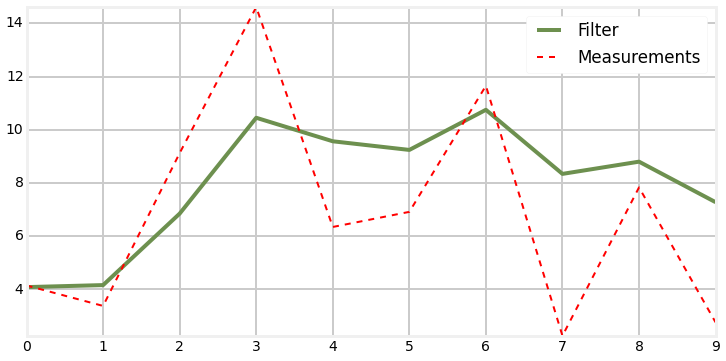

In [18]:
# assume dog is always moving 1m to the right
movement = 1
movement_variance = 2
sensor_variance = 10
pos = (0, 500)   # gaussian N(0,500)

dog = DogSensor(pos[0], velocity=movement, 
                measurement_variance=sensor_variance, 
                process_variance=sensor_variance)

zs = []
ps = []

for i in range(10):
    pos = predict(pos[0], pos[1], movement, movement_variance)
    print('PREDICT: {: 10.4f} {: 10.4f}'.format(pos[0], pos[1]),end='\t')
    
    Z = dog.sense_position()
    zs.append(Z)
    
    pos = update(pos[0], pos[1], Z, sensor_variance)
    ps.append(pos[0])
    
    print('UPDATE: {: 10.4f} {: 10.4f}'.format(pos[0], pos[1]))

    
bp.plot_filter(ps)
bp.plot_measurements(zs)
plt.legend(loc='best')
plt.show()

There is a fair bit of arbitrary constants code above, but don't worry about it. What does require explanation are the first few lines:

    movement = 1 
    movement_variance = 2
    
For the moment we are assuming that we have some other sensor that detects how the dog is moving. For example, there could be an inertial sensor clipped onto the dog's collar, and it reports how far the dog moved each time it is triggered. The details don't matter. The upshot is that we have a sensor, it has noise, and so we represent it with a Gaussian. Later we will learn what to do if we do not have a sensor for the `predict()` step.

For now let's walk through the code and output bit by bit.

    movement = 1
    movement_variance = 2
    sensor_variance = 10
    pos = (0, 500)   # gaussian N(0,500)
    
  
The first lines just set up the initial conditions for our filter. We are assuming that the dog moves steadily to the right 1m at a time. We have a relatively low error of 2 for the movement sensor, and a higher error of 10 for the RFID position sensor. Finally, we set our belief of the dog's initial position as $N(0,500)$. Why those numbers. Well, 0 is as good as any number if we don't know where the dog is. But we set the variance to 500 to denote that we have no confidence in this value at all. 100m is almost as likely as 0 with this value for the variance. 

Next we initialize the RFID simulator with

    dog = DogSensor(pos[0], velocity=movement, 
                    measurement_variance=sensor_variance, 
                    process_variance=sensor_variance)

It may seem very 'convenient' to set the simulator to the same position as our guess, and it is. Do not fret. In the next example we will see the effect of a wildly inaccurate guess for the dog's initial position.

The next code allocates an array to store the output of the measurements and filtered positions. 

    zs = []
    ps = []
    
This is the first time that I am introducing standard nomenclature used by the Kalman filtering literature. It is traditional to call our measurement $Z$, and so I follow that convention here. As an aside, I find the nomenclature used by the literature very obscure. However, if you wish to read the literature you will have to become used to it, so I will not use a much more readable variable name such as $m$ or $measure$.

Now we just enter our `update() ... predict()` loop.

    for i in range(10):
        pos = predict(pos[0], pos[1], movement, sensor_variance)
        print 'PREDICT:', "%.4f" %pos[0], ", %.4f" %pos[1]

Wait, why `predict()` before `update()`? It turns out the order does not matter once, but the first call to `,DogSensor.sense()` assumes that the dog has already moved, so we start with the update step. In practice you will order these calls based on the details of your sensor, and you will very typically do the `sense()` first.

So we call the update function with the Gaussian representing our current belief about our position, the another Gaussian representing our belief as to where the dog is moving, and then print the output. Your output will differ, but when writing this I get this as output:

    PREDICT: 1.000 502.000

What is this saying? After the prediction, we believe that we are at 1.0, and the variance is now 502.0. Recall we started at 500.0. The variance got worse, which is always what happens during the prediction step.

    Z = dog.sense_position()
    zs.append(Z)
    
Here we sense the dog's position, and store it in our array so we can plot the results later.

Finally we call the update function of our filter, save the result in our *ps* array, and print the updated position belief:

    pos = update(pos[0], pos[1], Z, movement_variance)
    ps.append(pos[0])
    print 'UPDATE:', "%.4f" %pos[0], ", %.4f" %pos[1]
    
Your result will be different, but I get

    UPDATE: 1.6279 , 9.8047
    
as the result. What is happening? Well, at this point the dog is really at 1.0, however the predicted position is 1.6279. What is happening is the RFID sensor has a fair amount of noise, and so we compute the position as 1.6279. That is pretty far off from 1, but this is just are first time through the loop. Intuition tells us that the results will get better as we make more measurements, so let's hope that this is true for our filter as well. Now look at the variance: 9.8047. It has dropped tremendously from 502.0. Why? Well, the RFID has a reasonably small variance of 2.0, so we trust it far more than our previous belief. At this point there is no way to know for sure that the RFID is outputting reliable data, so the variance is not 2.0, but is has gotten much better.

Now the software just loops, calling `predict()` and `update()` in turn. Because of the random sampling I do not know exactly what numbers you are seeing, but the final position is probably between 9 and 11, and the final variance is probably around 3.5. After several runs I did see the final position nearer 7, which would have been the result of several measurements with relatively large errors.

Now look at the plot. The noisy measurements are plotted in with a dotted red line, and the filter results are in the solid blue line. Both are quite noisy, but notice how much noisier the measurements (red line) are. This is your first Kalman filter shown to work!

In this example I only plotted 10 data points so the output from the print statements would not overwhelm us. Now let's look at the filter's performance with more data. This time we will plot both the output of the filter and the variance.

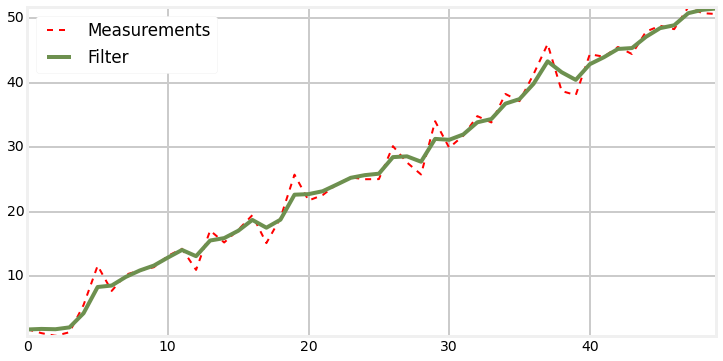

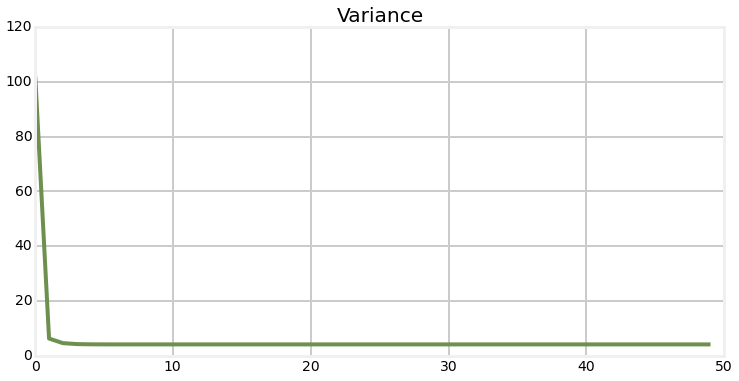

102.0000 6.3099 4.6267 4.2812 4.1939
4.1708 4.1646 4.1629 4.1624 4.1623
4.1623 4.1623 4.1623 4.1623 4.1623
4.1623 4.1623 4.1623 4.1623 4.1623
4.1623 4.1623 4.1623 4.1623 4.1623
4.1623 4.1623 4.1623 4.1623 4.1623
4.1623 4.1623 4.1623 4.1623 4.1623
4.1623 4.1623 4.1623 4.1623 4.1623
4.1623 4.1623 4.1623 4.1623 4.1623
4.1623 4.1623 4.1623 4.1623 4.1623


In [19]:
%precision 2
# assume dog is always moving 1m to the right
movement = 1
movement_variance = 2
sensor_variance = 4.5
pos = (0, 100)   # gaussian N(0,100)

dog = DogSensor(pos[0], velocity=movement, 
                measurement_variance=sensor_variance, 
                process_variance=0.5)

zs, ps, vs = [], [], []
for i in range(50):
    pos = predict(pos[0], pos[1], movement, movement_variance)    
    Z = dog.sense_position()
    zs.append(Z)
    vs.append(pos[1])
    
    pos = update(pos[0], pos[1], Z, sensor_variance)
    ps.append(pos[0])
       
bp.plot_measurements(zs)
bp.plot_filter(ps)
plt.legend(loc=2)
plt.show()

plt.plot(vs)
plt.title('Variance')
plt.show()

for i in range(0,len(vs), 5):
   print('{:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(*[v for v in vs[i:i+5]]))

Here we can see that the variance converges very quickly to roughly 4.1623 in 10 steps. We interpret this as meaning that we become very confident in our position estimate very quickly. The first few measurements are unsure due to our uncertainty in our guess at the initial position, but the filter is able to quickly determine an accurate estimate.

> Before I go on, I want to emphasize that this code fully implements a 1D Kalman filter. If you have tried to read the literature, you are perhaps surprised, because this looks nothing like the complex, endless pages of math in those books. To be fair, the math gets a bit more complicated in multiple dimensions, but not by much. So long as we worry about *using* the equations rather than *deriving* them we can create Kalman filters without a lot of effort. Moreover, I hope you'll agree that you have a decent intuitive grasp of what is happening. We represent our beliefs with Gaussians, and our beliefs get better over time because more measurement means more data to work with. "Measure twice, cut once!"

### Animating the Tracking

If you are reading this in IPython Notebook you will be able to see an animation of the filter tracking the dog directly below this sentence.
<img src='animations/05_dog_track.gif'>

The top plot shows the output of the filter in green, and the measurements with a dashed red line. The bottom plot shows the Gaussian at each step. 

When the track first starts you can see that the measurements varies quite a bit from the initial prediction. At this point the Gaussian probability is small (the curve is low and wide) so the filter does not trust its prediction. As a result, the filter adjusts its estimate a large amount. As the filter innovates you can see that as the Gaussian becomes taller, indicating greater certainty in the estimate, the filter's output becomes very close to a straight line. At `x=15` and greater you can see that there is a large amount of noise in the measurement, but the filter does not react much to it compared to how much it changed for the firs noisy measurement.

## Implementation in a Class

For many purposes the code above suffices. However, if you write enough of these filters the functions will become a bit annoying. For example, having to write

    pos = predict(pos[0], pos[1], movement, movement_variance) 
    
is a bit cumbersome and error prone. Let's investigate how we might implement this in a form that makes our lives easier.

First, values for the movement error and the measurement errors are typically constant for a given problem, so we only want to specify them once. We can store them in instance variables in the class. Second, it is annoying to have to pass in the state (pos in the code snippet above) and then remember to assign the output of the function back to that state, so the state should also be an instance variable. Our first attempt might look like:

    class KalmanFilter1D:
        def __init__(self, initial_state, measurement_variance, movement_variance):
            self.state = initial_state
            self.measurement_variance = measurement_variance
            self.movement_variance = movement_variance

That works, but I am going to use different naming. The Kalman filter literature has settled on one letter notations for each of these concepts, and so you might as well start getting exposed to it now. At first it seems impossibly terse, but as you become familiar with the nomenclature you'll see that the math formulas in the textbooks will have an exact one-to-one correspondence with the code. Unfortunately there is not a lot of meaning behind the names chosen; you will just have to memorize them. If you do not make this effort you will never be able to read the Kalman filter literature.

So, we use `x` for the state (estimated value of the filter) and `P` for the variance of the state. `R` is the measurement error, and `Q` is the movement error. This gives us:

    class KalmanFilter1D:
        def __init__(self, x0, R, Q):
            self.x = x0
            self.R = R
            self.Q = Q
            
Now we can implement the `update()` and `predict()` function. In the literature the measurement is usually named either `z` or `y`; I find `y` is too easy to confuse with the y axis of a plot, so I like `z`. I like to think I can hear a `z` in *measurement*, which helps me remember what `z` stands for. So for the update method we might write:

    def update(z):
        self.x = (self.P * z + self.x * self.R) / (self.P + self.R)
        self.P = 1 / (1/self.P + 1/self.R)

Finally, the movement is usually called `u`, and so we will use that. So for the predict function we might write:

    def predict(self, u):
        self.x += u
        self.P += self.Q
       
That give us the following code. Production code would require significant comments. However, in the next chapter we will develop Kalman filter code that works for any dimension, including 1, so this class will never be more than a stepping stone for us, since we can, and will use the class developed in the next chapter in the rest of the book.

In [20]:
class KalmanFilter1D:
    def __init__(self, x0, P, R, Q):
        self.x = x0
        self.P = P
        self.R = R
        self.Q = Q


    def update(self, z):
        self.x = (self.P * z + self.x * self.R) / (self.P + self.R)
        self.P = 1. / (1./self.P + 1./self.R)


    def predict(self, u=0.0):
        self.x += u
        self.P += self.Q

## Relationship to the g-h Filter

In the first chapter I stated that the Kalman filter is a form of g-h filter. However, we have been reasoning about the probability of Gaussians, and not used any of the reasoning or equations of the first chapter. A trivial amount of algebra will reveal the relationship, so let's do that now. It's not particularly illuminating algebra, so feel free to skip to the bottom to see the final equation that relates *g* and *h* to the variances.

The equation for our estimate is:

$$
\mu_{x'}=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}
$$

which I will make more friendly for our eyes as:

$$
\mu_{x'}=\frac{ya + xb} {a+b}
$$

We can easily put this into the g-h form with the following algebra

$$
\begin{aligned}
\mu_{x'}&=(x-x) + \frac{ya + xb} {a+b} \\
\mu_{x'}&=x-\frac{a+b}{a+b}x  + \frac{ya + xb} {a+b} \\ 
\mu_{x'}&=x +\frac{-x(a+b) + xb+ya}{a+b} \\
\mu_{x'}&=x+ \frac{-xa+ya}{a+b}  \\
\mu_{x'}&=x+ \frac{a}{a+b}(y-x)\\
\end{aligned}
$$

We are almost done, but recall that the variance of estimate is given by 

$${\sigma_{x'}^2} = \frac{1}{ \frac{1}{\sigma_1^2} +  \frac{1}{\sigma_2^2}}\\
= \frac{1}{ \frac{1}{a} +  \frac{1}{b}}
$$

We can incorporate that term into our equation above by observing that
$$ 
\begin{aligned}
\frac{a}{a+b} &= \frac{a/a}{(a+b)/a} = \frac{1}{(a+b)/a}\\
 &= \frac{1}{1 + \frac{b}{a}} = \frac{1}{\frac{b}{b} + \frac{b}{a}}\\
 &= \frac{1}{b}\frac{1}{\frac{1}{b} + \frac{1}{a}} \\
 &= \frac{\sigma^2_{x'}}{b}
 \end{aligned}
$$

We can tie all of this together with

$$
\begin{aligned}
\mu_{x'}&=x+ \frac{a}{a+b}(y-x)\\
&= x + \frac{\sigma^2_{x'}}{b}(y-x) \\
&= x + g_n(y-x)\\
\blacksquare
\end{aligned}
$$

where

$$g_n = \frac{\sigma^2_{x'}}{\sigma^2_{y}}$$

The end result is multiplying the residual of the two measurements by a constant and adding to our previous value, which is the *g* equation for the g-h filter. *g* is the variance of the new estimate divided by the variance of the measurement. Of course in this case g is not truly a constant, as it varies with each time step as the variance changes, but it is truly the same formula. We can also derive the formula for *h* in the same way but I don't find this a particularly interesting derivation. The end result is

$$h_n = \frac{COV (x,\dot{x})}{\sigma^2_{y}}$$

The takeaway point is that *g* and *h* are specified fully by the variance and covariances of the measurement and predictions at time *n*. In other words, we are just picking a point between the measurement and prediction by a scale factor determined by the quality of each of those two inputs. That is all the Kalman filter is. 

### Exercise: Modify Variance Values

Modify the values of `movement_variance` and `sensor_variance` and note the effect on the filter and on the variance. Which has a larger effect on the value that variance converges to. For example, which results in a smaller variance:

    movement_variance = 40
    sensor_variance = 2
    
or:

    movement_variance = 2
    sensor_variance = 40

## Introduction to Designing a Filter

So far we have developed our filter based on the dog sensors introduced in the Discrete Bayesian filter chapter. We are used to this problem by now, and may feel ill-equipped to implement a Kalman filter for a different problem. To be honest, there is still quite a bit of information missing from this presentation. The next chapter will fill in the gaps. Still, lets get a feel for it by designing and implementing a Kalman filter for a thermometer. The sensor for the thermometer outputs a voltage that corresponds to the temperature that is being measured. We have read the manufacturer's specifications for the sensor, and it tells us that the sensor exhibits white noise with a standard deviation of 2.13.

We do not have a real sensor to read, so we will simulate the sensor with the following function. 

In [21]:
def volt(voltage, temp_variance):
    return random.randn()*temp_variance + voltage

We generate white noise with a given variance using the equation `random.randn() * variance`. The specification gives us the standard deviation of the noise, not the variance, but recall that variance is just the square of the standard deviation. Hence we raise 2.13 to the second power.

> **Sidebar**: spec sheets are just what they sound like - specifications. Any individual sensor will exhibit different performance based on normal manufacturing variations. Numbers given are often maximums - the spec is a guarantee that the performance will be at least that good. So, our sensor might have standard deviation of 1.8. If you buy an expensive piece of equipment it often comes with a sheet of paper displaying the test results of your specific item; this is usually very trustworthy. On the other hand, if this is a cheap sensor it is likely it received little to no testing prior to being sold. Manufacturers typically test a small subset of their output to verify that everything falls within the desired performance range. If you have a critical application you will need to read the specification sheet carefully to figure out exactly what they mean by their ranges. Do they guarantee their number is a maximum, or is it, say, the $3\sigma$ error rate? Is every item tested? Is the variance normal, or some other distribution. Finally, manufacturing is not perfect. Your part might be defective and not match the performance on the sheet.

> For example, I just randomly looked up a data sheet for an airflow sensor. There is a field *Repeatability*, with the value $\pm 0.50\%$. Is this a Gaussian? Is there a bias? For example, perhaps the repeatability is nearly 0.0% at low temperatures, and always nearly  +0.50 at high temperatures. Data sheets for electrical components often contain a section of "Typical Performance Characteristics". These are used to capture information that cannot be easily conveyed in a table. For example, I am looking at a chart showing output voltage vs current for a LM555 timer. There are three curves showing the performance at different temperatures. The response is ideally linear, but all three lines are curved. This clarifies that errors in voltage outputs are probably not Gaussian - in this chip's case higher temperatures leads to lower voltage output, and the voltage output is quite nonlinear if the input current is very high. 

> As you might guess, modeling the performance of your sensors is one of the harder parts of creating a Kalman filter that performs well. 

Now we need to write the Kalman filter processing loop. As with our previous problem, we need to perform a cycle of predicting and updating. The sensing step probably seems clear - call `volt()` to get the measurement, pass the result into `update()` function, but what about the predict step? We do not have a sensor to detect 'movement' in the voltage, and for any small duration we expect the voltage to remain constant. How shall we handle this?

As always, we will trust in the math. We have no known movement, so we will set that to zero. However, that means that we are predicting that the temperature will never change over time. If that is true, then over time we should become extremely confident in our results. Once the filter has enough measurements it will become very confident that it can predict the subsequent temperatures, and this will lead it to ignoring measurements that result due to an actual temperature change. This is called a *smug* filter, and is something you want to avoid. So we will add a bit of error to our prediction step to tell the filter not to discount changes in voltage over time. In the code below I set `movement_variance = .2`. This is just the expected variance in the change of voltage over each time step. I chose this value merely to be able to show how the variance changes through the update and predict steps. For an real sensor you would set this value for the actual amount of change you expect. For example, this would be an extremely small number if it is a thermometer for ambient air temperature in a house, and a high number if this is a thermocouple in a chemical reaction chamber. We will say more about selecting the actual value in the next chapter. 

Let's see what happens. 

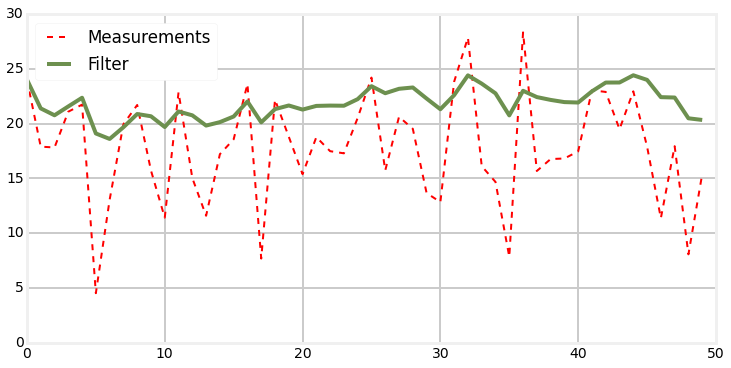

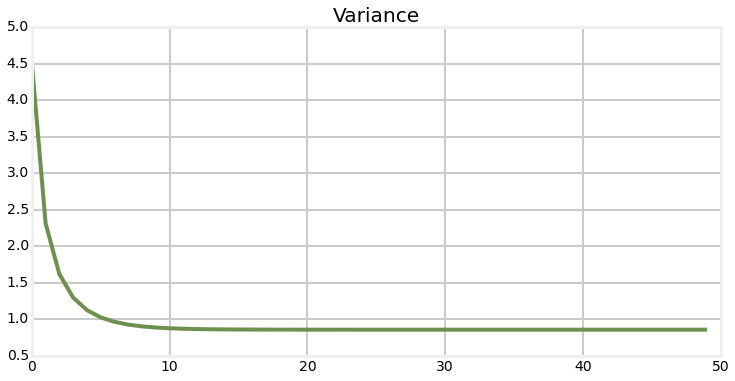

Variance converges to 0.858


In [22]:
variance = 2.13**2
movement_variance = .2
actual_voltage = 16.3

N=50
zs = [volt(actual_voltage, variance) for i in range(N)]
ps = []
estimates = []

kf = KalmanFilter1D(x0=25,            # initial state
                    P = 1000,         # initial variance 
                                      # large says 'who knows?'
                    R=variance,       # sensor noise
                    Q=movement_variance) # movement noise

for i in range(N):
    kf.predict(movement)
    kf.update(zs[i])

    # save for latter plotting
    estimates.append(kf.x)
    ps.append(kf.P)

# plot the filter output and the variance
bp.plot_measurements(zs)
bp.plot_filter(estimates)
plt.legend(loc='best')
plt.xlim((0,N));plt.ylim((0,30))
plt.show()
plt.plot(ps)
plt.title('Variance')
plt.show()
print('Variance converges to {:.3f}'.format(ps[-1]))

The first plot shows the individual sensor measurements marked with '+'s vs the filter output. Despite a lot of noise in the sensor we quickly discover the approximate voltage of the sensor. In the run I just completed at the time of authorship, the last voltage output from the filter is $16.213$, which is quite close to the $16.4$ used by the `volt()` function. On other runs I have gotten up to around $16.9$ as an output and also as low as 15.5 or so.

The second plot shows how the variance converges over time. Compare this plot to the variance plot for the dog sensor. While this does converge to a very small value, it is much slower than the dog problem. The section **Explaining the Results - Multi-Sensor Fusion** explains why this happens.

### Animation

For those reading this in IPython Notebook, here is an animation showing the filter working. The top plot in the animation draws a green line for the predicted next voltage, then a red '+' for the actual measurement, draws a light red line to show the residual, and then draws a blue line to the filter's output. You can see that when the filter starts the corrections made are quite large, but after only a few updates the filter only adjusts its output by a small amount even when the measurement is far from it. 

The lower plot shows the Gaussian belief as the filter innovates. When the filter starts the Gaussian curve is centered over 25, our initial guess for the voltage, and is very wide and short due to our initial uncertainty. But as the filter innovates, the Gaussian quickly moves to about 16.0 and becomes taller, reflecting the growing confidence that the filter has in it's estimate for the voltage. You will also note that the Gaussian's height bounces up and down a little bit. If you watch closely you will see that the Gaussian becomes a bit shorter and more spread out during the prediction step, and becomes taller and narrower as the filter incorporates another measurement (the innovation step).

<img src='animations/05_volt_animate.gif'>

Think of this animation in terms of the g-h filter. At each step the g-h filter makes a prediction, takes a measurement, computes the residual (the difference between the prediction and the measurement, and then selects a point on the residual line based on the scaling factor *g*. The Kalman filter is doing exactly the same thing, except that the scaling factor *g* varies with time. As the filter becomes more confident in its state the scaling factor favors the filter's prediction over the measurement. 

> If this is not clear, I urge you to go back and review the g-h chapter. This is the crux of the algorithms in this book. 

## Exercise(optional):

Write a function that runs the Kalman filter many times and record what value the voltage converges to each time. Plot this as a histogram. After 10,000 runs do the results look normally distributed? Does this match your intuition of what should happen?

> use plt.hist(data,bins=100) to plot the histogram. 

In [23]:
#Your code here

### Solution

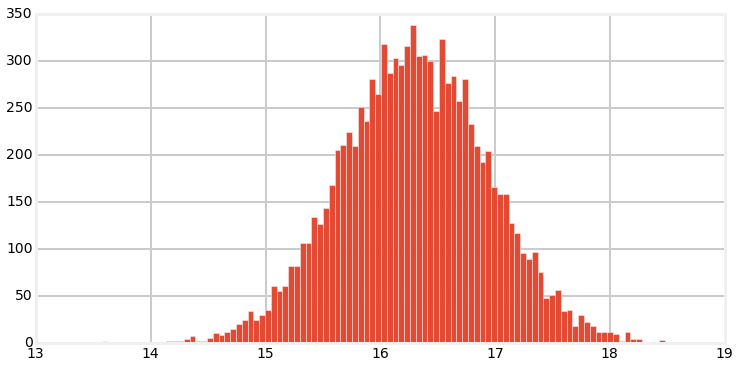

In [24]:
variance = 2.13**2
actual_voltage = 16.3


def VKF():
    voltage=(14,1000)
    for i in range(N):
        Z = volt(actual_voltage, variance)
        voltage = update(voltage[0], voltage[1], Z, variance)
    return voltage[0]

vs = []
for i in range (10000):
    vs.append (VKF())
plt.hist(vs, bins=100, color='#e24a33')   
plt.show()

### Discussion

The results do in fact look like a normal distribution. Each voltage is Gaussian, and the **Central Limit Theorem** guarantees that a large number of Gaussians is normally distributed. We will discuss this more in a subsequent math chapter.

## Explaining the Results - Multi-Sensor Fusion

**author's note:** I am not overly keen about this explanation. It is true that multiple sensors improve results, but we get good results merely by having an accurate model of the process. I explain this much better in the next chapter. I'll leave this section here while I mull how best to explain this at this stage of learning. For now don't worry if this section is not entirely convincing; it does need work.

So how does the Kalman filter do so well? I have glossed over one aspect of the filter as it becomes confusing to address too many points at the same time. We will return to the dog tracking problem. We used two sensors to track the dog - the RFID sensor that detects position, and the inertial tracker that tracked movement. However, we have focused all of our attention on the position sensor. Let's change focus and see how the filter performs if the inertial tracker is also noisy. This will provide us with an vital insight into the performance of Kalman filters.

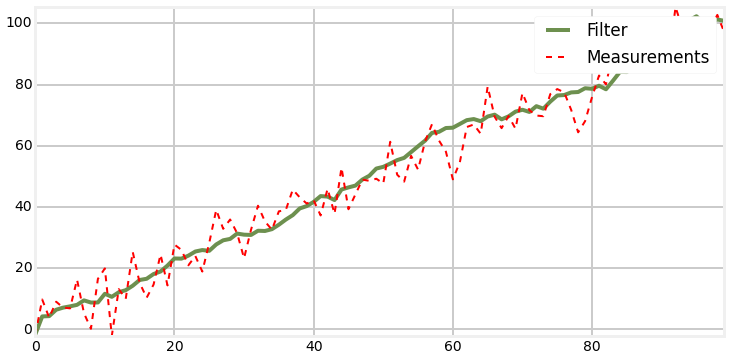

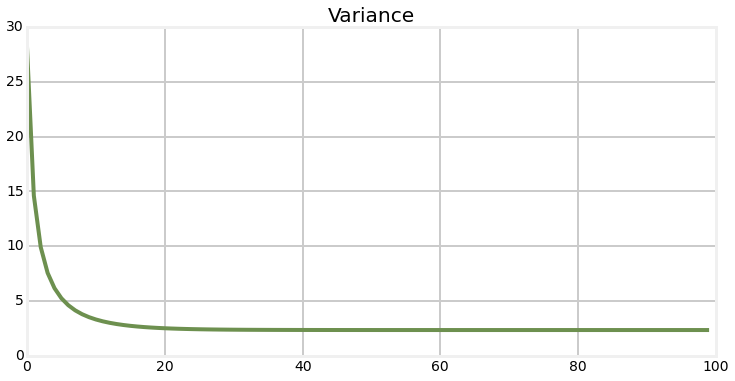

In [25]:
sensor_variance = 30
movement_sensor = 30
pos = (0,500)

dog = DogSensor(0, velocity=movement, 
                measurement_variance=sensor_variance,
                process_variance=0.5)

zs = []
ps = []
vs = []

for i in range(100):
    Z = dog.sense_position()
    zs.append(Z)
    
    pos = update(pos[0], pos[1], Z, sensor_variance)
    ps.append(pos[0])
    vs.append(pos[1])

    pos = predict(pos[0], pos[1], movement+ random.randn(), movement_variance)

bp.plot_filter(ps)
bp.plot_measurements(zs)
plt.legend()
plt.show()
plt.plot(vs)
plt.title('Variance')
plt.show()

This result is worse than the example where only the measurement sensor was noisy. Instead of being mostly straight, this time the filter's output is distinctly jagged. But, it still mostly tracks the dog. What is happening here?

This illustrates the effects of *multi-sensor fusion*. Suppose we get a position reading of -28.78 followed by 31.43.  From that information alone it is impossible to tell if the dog is standing still during very noisy measurements, or perhaps sprinting from -29 to 31 and being accurately measured. But we have a second source of information, his velocity. Even when the velocity is also noisy, it constrains what our beliefs might be. For example, suppose that with the 31.43 position reading we get a velocity reading of 59. That matches the difference between the two positions quite well, so this will lead us to believe the RFID sensor and the velocity sensor. Now suppose we got a velocity reading of 1.7. This doesn't match our RFID reading very well - it suggests that the dog is standing still or moving slowly.

When sensors measure different aspects of the system and they all agree we have strong evidence that the sensors are accurate. And when they do not agree it is a strong indication that one or more of them are inaccurate. 

We will formalize this mathematically in the next chapter; for now trust this intuitive explanation. We use this sort of reasoning every day in our lives. If one person tells us something that seems far fetched we are inclined to doubt them. But if several people independently relay the same information we attach higher credence to the data. If one person disagrees with several other people, we tend to distrust the outlier. If we know the people that might alter our belief. If a friend is inclined to practical jokes and tall tales we may put very little trust in what they say. If one lawyer and three lay people opine on some fact of law, and the lawyer disagrees with the three you'll probably lend more credence to what the lawyer says because of her expertise. In the next chapter we will learn how to mathematical model this sort of reasoning.

## More examples

### Example: Extreme Amounts of Noise

So I didn't put a lot of noise in the signal, and I also 'correctly guessed' that the dog was at position 0. How does the filter perform in real world conditions? Let's explore and find out. I will start by injecting a lot of noise in the RFID sensor. I will inject an extreme amount of noise - noise that apparently swamps the actual measurement. What does your intuition tell about how the filter will perform if the noise is allowed to be anywhere from -300 or 300. In other words, an actual position of 1.0 might be reported as 287.9, or -189.6, or any other number in that range. Think about it before you scroll down.

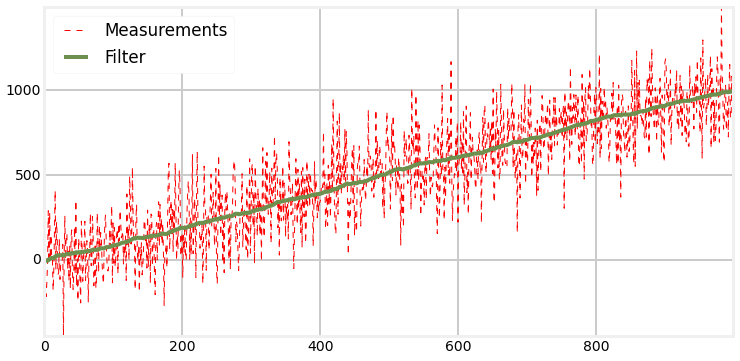

In [26]:
sensor_variance = 30000
movement_variance = 2
pos = (0,500)

dog = DogSensor(pos[0], velocity=movement, measurement_variance=sensor_variance)

zs = []
ps = []

for i in range(1000):
    pos = predict(pos[0], pos[1], movement, movement_variance)
    
    Z = dog.sense_position()
    zs.append(Z)
    
    pos = update(pos[0], pos[1], Z, sensor_variance)
    ps.append(pos[0])


bp.plot_measurements(zs, lw=1)
bp.plot_filter(ps)
plt.legend(loc='best')
plt.show()

In this example the noise is extreme yet the filter still outputs a nearly straight line! This is an astonishing result! What do you think might be the cause of this performance? If you are not sure, don't worry, we will discuss it latter.

### Example: Bad Initial Estimate


Now let's lets look at the results when we make a bad initial estimate of position. To avoid obscuring the results I'll reduce the sensor variance to 30, but set the initial position to 1000m. Can the filter recover from a 1000m initial error?

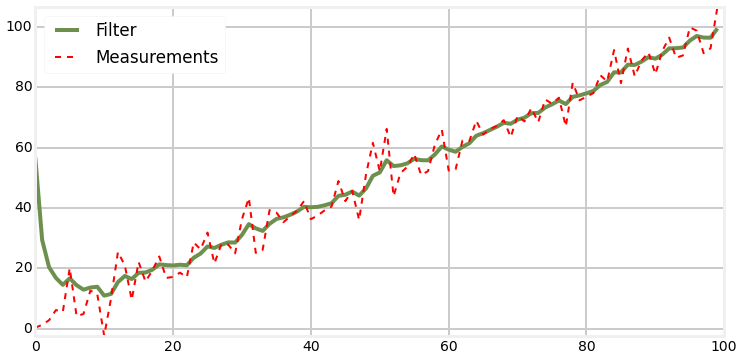

In [27]:
sensor_variance = 30
movement_variance = 2
pos = (1000,500)

dog = DogSensor(0, velocity=movement, measurement_variance=sensor_variance)

zs = []
ps = []

for i in range(100):
    pos = predict(pos[0], pos[1], movement, movement_variance)
    
    Z = dog.sense_position()
    zs.append(Z)
    
    pos = update(pos[0], pos[1], Z, sensor_variance)
    ps.append(pos[0])

bp.plot_filter(ps)
bp.plot_measurements(zs)
plt.legend(loc='best')
plt.gca().set_xlim(0,100)
plt.show()

Again the answer is yes! Because we are relatively sure about our belief in the sensor ($\sigma=30$) even after the first step we have changed our belief in the first position from 1000 to somewhere around 60.0 or so. After another 5-10 measurements we have converged to the correct value! So this is how we get around the chicken and egg problem of initial guesses. In practice we would probably just assign the first measurement from the sensor as the initial value, but you can see it doesn't matter much if we wildly guess at the initial conditions - the Kalman filter still converges very quickly.

### Example: Large Noise and Bad Initial Estimate

What about the worst of both worlds, large noise and a bad initial estimate?

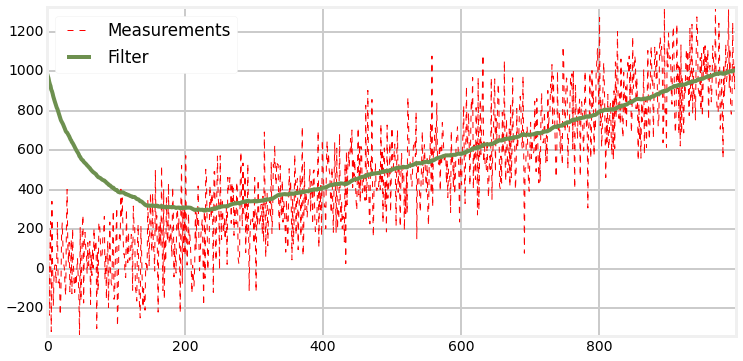

In [28]:
sensor_variance = 30000
movement_variance = 2
pos = (1000,500)


dog = DogSensor(0, velocity=movement, measurement_variance=sensor_variance) 
zs = []
ps = []

for i in range(1000):
    pos = predict(pos[0], pos[1], movement, movement_variance)
    
    Z = dog.sense_position()
    zs.append(Z)
    
    pos = update(pos[0], pos[1], Z, sensor_variance)
    ps.append(pos[0])

bp.plot_measurements(zs, lw=1)
bp.plot_filter(ps)
plt.legend(loc='best')
plt.show()

This time the filter does struggle. Notice that the previous example only computed 100 updates, whereas this example uses 1000. By my eye it takes the filter 400 or so iterations to become reasonable accurate, but maybe over 600 before the results are good. Kalman filters are good, but we cannot expect miracles. If we have extremely noisy data and extremely bad initial conditions, this is as good as it gets.

Finally, let's make the suggest change of making our initial position guess just be the first sensor measurement.

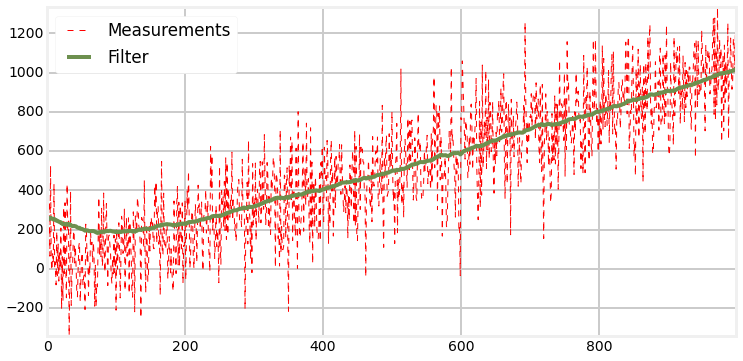

In [29]:
sensor_variance = 30000
movement_variance = 2
pos = None

dog = DogSensor(0, velocity=movement, measurement_variance=sensor_variance)

zs = []
ps = []

for i in range(1000):
    Z = dog.sense_position()
    zs.append(Z)
    if pos == None:
        pos = (Z, 500)
    
    pos = update(pos[0], pos[1], Z, sensor_variance)
    ps.append(pos[0])

    pos = predict(pos[0], pos[1], movement, movement_variance)

bp.plot_measurements(zs, lw=1)
bp.plot_filter(ps)
plt.legend(loc='best')
plt.show()

This simple change significantly improves the results. On some runs it takes 200 iterations or so to settle to a good solution, but other runs it converges very rapidly. This all depends on whether the initial measurement $Z$ had a small amount or large amount of noise. 

200 iterations may seem like a lot, but the amount of noise we are injecting is truly huge. In the real world we use sensors like thermometers,  laser range finders, GPS satellites, computer vision, and so on. None have the enormous error as shown here. A reasonable value for the variance for a cheap thermometer might be 10, for example, and our code is using 30,000 for the variance. 

## Exercise: Interactive Plots

Implement the Kalman filter using IPython Notebook's animation features to allow you to modify the various constants in real time using sliders. Refer to the section **Interactive Gaussians** in the Gaussian chapter to see how to do this. You will use the `interact()` function to call a calculation and plotting function. Each parameter passed into `interact()` automatically gets a slider created for it. I have built the boilerplate for this; just fill in the required code.

In [30]:
from IPython.html.widgets import interact, interactive, fixed
import IPython.html.widgets as widgets


def plot_kalman_filter(start_pos, 
                       sensor_noise, 
                       movement, 
                       movement_noise,
                       noise_scale):
    # your code goes here
    pass

interact(plot_kalman_filter,
         start_pos=(-10,10), 
         sensor_noise=widgets.IntSliderWidget(value=5, min=0, max=100), 
         movement=widgets.FloatSliderWidget(value=1, min=-2., max=2.), 
         movement_noise=widgets.FloatSliderWidget(value=5, min=0, max=100.),
         noise_scale=widgets.FloatSliderWidget(value=1, min=0, max=2.))

<function __main__.plot_kalman_filter>

### Solution

One possible solution follows. We have sliders for the start position, the amount of noise in the sensor, the amount we move in each time step, and how much movement error there is. Movement error is perhaps the least clear - it models how much the dog wanders off course at each time step, so we add that into the dog's position at each step. I set the random number generator seed so that each redraw uses the same random numbers, allowing us to compare the graphs as we move the sliders.

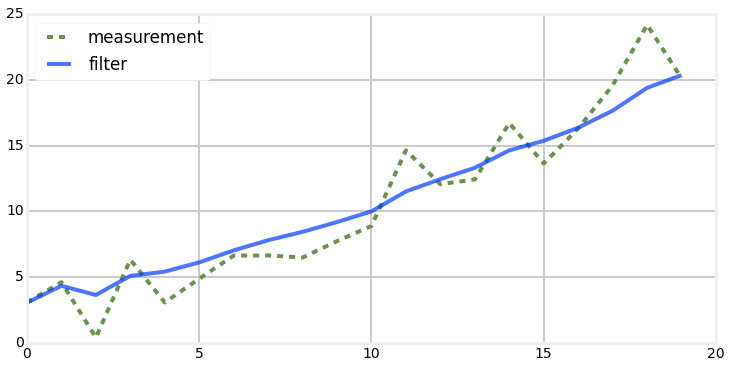

<function __main__.plot_kalman_filter>

In [31]:
def plot_kalman_filter(start_pos, 
                       sensor_noise, 
                       movement,
                       movement_noise):
    n = 20
    zs = []
    ps = []
    
    dog = DogSensor(start_pos, velocity=movement, measurement_variance=sensor_noise)
    random.seed(303)
    pos = (0., 1000.) # mean and variance

    for _ in range(n):       
        move_error = random.randn()*movement_noise
        dog.x += move_error
        
        z = dog.sense_position()
        zs.append(z)

        pos = update(pos[0], pos[1], z, sensor_noise)
        ps.append(pos[0])

        pos = predict(pos[0], pos[1], movement, movement_noise)

    plt.plot(zs, c='r', linestyle='dashed', label='measurement')
    plt.plot(ps, c='#004080', alpha=0.7, label='filter')
    plt.legend(loc='best')
    plt.show()

interact(plot_kalman_filter,
         start_pos=(-10, 10), 
         sensor_noise=widgets.FloatSliderWidget(value=5, min=0., max=100), 
         movement=widgets.FloatSliderWidget(value=1, min=-2., max=2.), 
         movement_noise=widgets.FloatSliderWidget(value=.1, min=0, max=.5))

## Exercise - Nonlinear Systems

Our equations are linear: 
$$\begin{aligned}new\_pos &= old\_pos+dist\_moved\\
new\_position &= old\_position*measurement\end{aligned}$$

Do you suppose that this filter works well or poorly with nonlinear systems?

Implement a Kalman filter that uses the following equation to generate the measurement value for i in range(100):

    Z = math.sin(i/3.) * 2
    
Adjust the variance and initial positions to see the effect. What is, for example, the result of a very bad initial guess?

In [32]:
#enter your code here.

### Solution

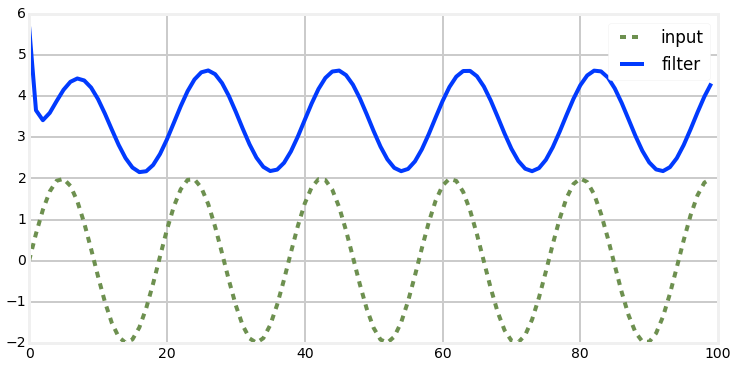

In [33]:
sensor_variance = 30
movement_variance = 2
pos = (100,500)

zs, ps = [], []

for i in range(100):
    pos = predict(pos[0], pos[1], movement, movement_variance)

    Z = math.sin(i/3.)*2
    zs.append(Z)
    
    pos = update(pos[0], pos[1], Z, sensor_variance)
    ps.append(pos[0])

plt.plot(zs, c='r', linestyle='dashed', label='input')
plt.plot(ps, c='#004080', label='filter')
plt.legend(loc='best')
plt.show()

### Discussion

Here we set a bad initial guess of 100. We can see that the filter never 'acquires' the signal. Note now the peak of the filter output always lags the peak of the signal by a small amount, and how the filtered signal does not come very close to capturing the high and low peaks of the input signal.

If we recall the g-h filter chapter we can understand what is happening here. The structure of the g-h filter requires that the filter output chooses a value part way between the prediction and measurement. A varying signal like this one is always accelerating, whereas our process model assumes constant velocity, so the filter is mathematically guaranteed to always lag the input signal. 

Maybe we just didn't adjust things 'quite right'. After all, the output looks like a sin wave, it is just offset some. Let's test this assumption.

## Exercise - Noisy Nonlinear Systems

Implement the same system, but add noise to the measurement.

In [34]:
#enter your code here

### Solution

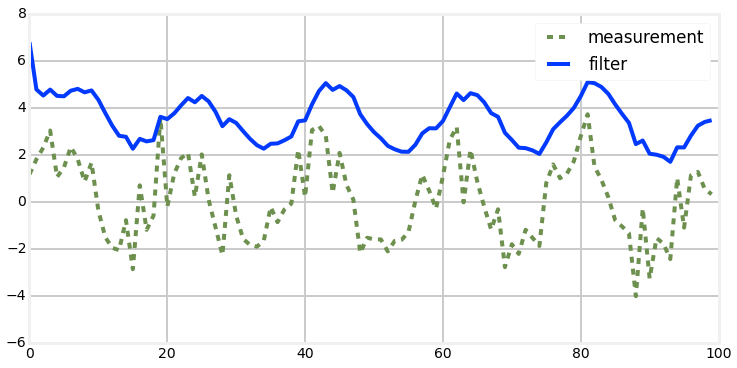

In [35]:
sensor_variance = 30
movement_variance = 2
pos = (100,500)

zs, ps = [], []

for i in range(100):
    pos = predict(pos[0], pos[1], movement, movement_variance)

    Z = math.sin(i/3.)*2 + random.randn()*1.2
    zs.append(Z)
    
    pos = update(pos[0], pos[1], Z, sensor_variance)
    ps.append(pos[0])

p1, = plt.plot(zs, c='r', linestyle='dashed', label='measurement')
p2, = plt.plot(ps, c='#004080', label='filter')
plt.legend(loc='best')
plt.show()

### Discussion

This is terrible! The output is not at all like a sin wave, except in the grossest way. With linear systems we could add extreme amounts of noise to our signal and still extract a very accurate result, but here even modest noise creates a very bad result.

Very shortly after practitioners began implementing Kalman filters they recognized the poor performance of them for nonlinear systems and began devising ways of dealing with it. Much of the remainder of this book is devoted to this problem and its various solutions.

## Summary

This information in this chapter takes some time to assimilate. To truly understand this you will probably have to work through this chapter several times. I encourage you to change the various constants and observe the results. Convince yourself that Gaussians are a good representation of a unimodal belief of something like the position of a dog in a hallway. Then convince yourself that multiplying Gaussians truly does compute a new belief from your prior belief and the new measurement. Finally, convince yourself that if you are measuring movement, that adding the Gaussians correctly updates your belief. That is all the Kalman filter does. Even now I alternate between complacency and amazement at the results. 

If you understand this, you will be able to understand multidimensional Kalman filters and the various extensions that have been make on them. If you do not fully understand this, I strongly suggest rereading this chapter. Try implementing the filter from scratch, just by looking at the equations and reading the text. Change the constants. Maybe try to implement a different tracking problem, like tracking stock prices. Experimentation will build your intuition and understanding of how these marvelous filters work.